# Dictionary Learning with Perturb-seq data

William Colgan, May 12 2020

### Setup

In [324]:
library(useful)
library(umap)
library(magrittr)
library(reshape2)
library(progeny)
library(tidyverse)
library(pheatmap)
library(ggrepel)
source("./lib/helpers.R")

### Load data

In [ ]:
obs = read_csv("./data/K562_gwps_obs.csv")
var = read_csv("./data/K562_gwps_var.csv")
mat = read_csv("./data/K562_gwps_norm.csv",col_names = F)
mat <- mat %>% as.matrix()
colnames(mat) <- var$gene_name
rownames(mat) <- obs$gene_transcript %>% word(2,2,sep = "_")
mat = t(mat)
mat[mat > 5]  <-  5
mat[mat < -5]  <-  -5

In [370]:
scaled  <- apply(mat,2,scale,center = T,scale = T) %>% apply(1,scale,center = T)  %>% t()
rownames(scaled)  <- rownames(mat)
colnames(scaled)  <- colnames(mat)

### Run Webster

In [362]:
export_for_matlab(scaled, "./output/scaled.csv")
export_for_matlab(mat, "./output/gwps.csv")

Run tune_k.m to iterate over k values and save results

### Find optimal k

In [34]:
f_norm = c()
for (k in seq(10,300,5)){
    temp  <- R.matlab::readMat(str_c("./output/interim/gwps-K=",k,"-T=4.mat"))
    dict <- as.matrix(temp$D)
    loading  <- as.matrix(temp$X)
    f_norm %<>% append(norm(mat - (dict %*% loading),type = "F"))
}
df = tibble(f_norm = f_norm, k = seq(10,300,5))

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


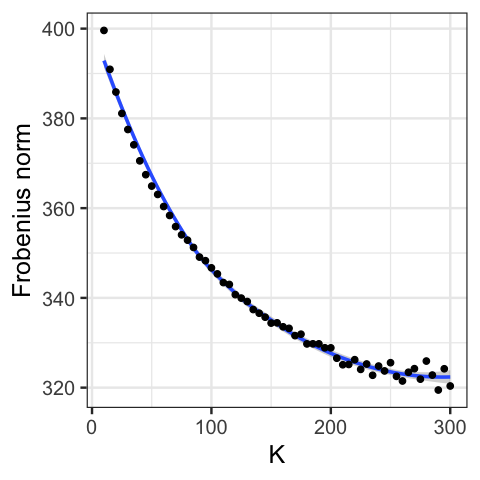

In [59]:
options(repr.plot.width=4, repr.plot.height=4)
p  <-  df  %>% ggplot(aes(x = k, y = f_norm)) + geom_smooth() + geom_point() + theme_bw(base_size = 15) + 
    labs(x = "K", y = "Frobenius norm")
ggsave("./output/dictionary_learning/fnorm_vs_k.svg",p,width = 4, height = 4, units = "in",dpi = 300)
p

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
"Removed 1 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
"Removed 1 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."


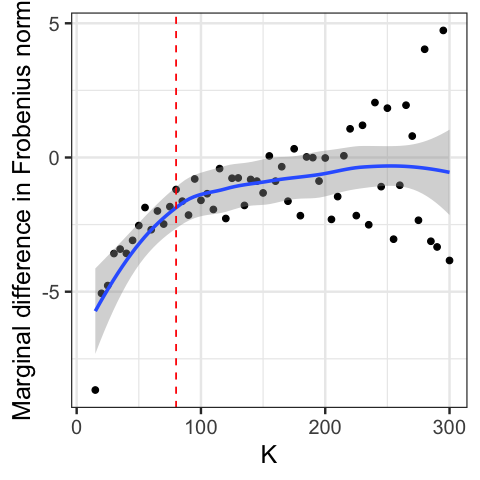

In [79]:
options(repr.plot.width=4, repr.plot.height=4)
df  %<>% mutate(diff = c(NA,diff(f_norm)))
p  <- df  %>% ggplot(aes(x = k, y = diff)) + geom_point() + geom_smooth() + geom_vline(xintercept = 80,linetype="dashed",color = "red")  + theme_bw(base_size = 15) + 
    labs(x = "K", y = "Marginal difference in Frobenius norm")
ggsave("./output/dictionary_learning/diff_fnorm_vs_k.svg",p,width = 4, height = 4, units = "in",dpi = 300)
p

### Check sparsity

In [363]:
temp  <- R.matlab::readMat("./output/interim/scaled-gwps-K=80-T=4.mat")
dict <- as.matrix(temp$D)
loading  <- as.matrix(temp$X)
colnames(loading)  <- colnames(mat)
names  <- c()
for (i in 1:nrow(loading)) {
  names  %<>% append(c(paste0("P",i)))
}
rownames(loading)  <- names
colnames(dict) <- names

In [364]:
df = melt(loading)
df %<>% setNames(c("program","gene","loading"))
df  %<>% group_by(gene)  %>% mutate(loading = loading/sum(abs(loading)))  %>% 
    mutate(rank = rank(desc(abs(loading)), ties.method = "random")) %>% ungroup()


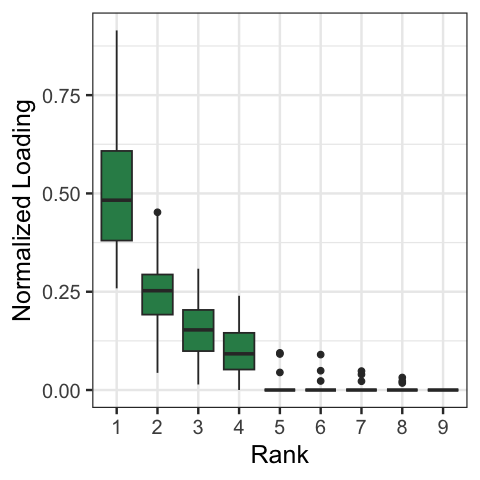

In [365]:
options(repr.plot.width=4, repr.plot.height=4)
p <- df  %>% filter(rank < 10) %>% ggplot(aes(as.character(rank),abs(loading),group = rank)) + geom_boxplot(fill = "seagreen") + theme_bw(base_size = 15) + 
    labs(x = "Rank", y = "Normalized Loading")
    ggsave("./output/dictionary_learning/loading_vs_rank.svg",p,width = 4, height = 4, units = "in",dpi = 300)
p

### Similarity to tf targets

In [267]:
gene_sets  <- read_rds("./data/gsc-data-term2gene")
ChEA <- gene_sets$ChEA
ChEA  %<>% filter(str_detect(term,"Human"))

In [368]:
pca <- prcomp(t(scaled),scale = F,center = F,rank = 80)

In [441]:
tf_cor_list  <- list()
for (x in ChEA$term  %>% unique()) {
    if(length(intersect(rownames(scaled),ChEA  %>% filter(term == x)  %>% .$gene)) > 10) {
        q  <- scaled[intersect(rownames(scaled),ChEA  %>% filter(term == x)  %>% .$gene),]  %>% colMeans()
        loading_cor <- cor(q,t(as.matrix(loading))) %>% t()  %>% as_tibble(rownames = "program")  %>% mutate(method = "DGRDL")
        pca_cor <-cor(q,pca$x[,1:80]) %>% t()  %>% as_tibble(rownames = "program") %>% mutate(method = "PCA")
        tf_cor_list  %<>% append(list(bind_rows(loading_cor,pca_cor)  %>% mutate(term = x)))
    }
}
tf_cor <- bind_rows(tf_cor_list)
tf_cor  %<>% mutate(tf = word(term,1,1))

In [447]:
tf_list  <- tf_cor$term  %>% unique()  %>% sample(9)

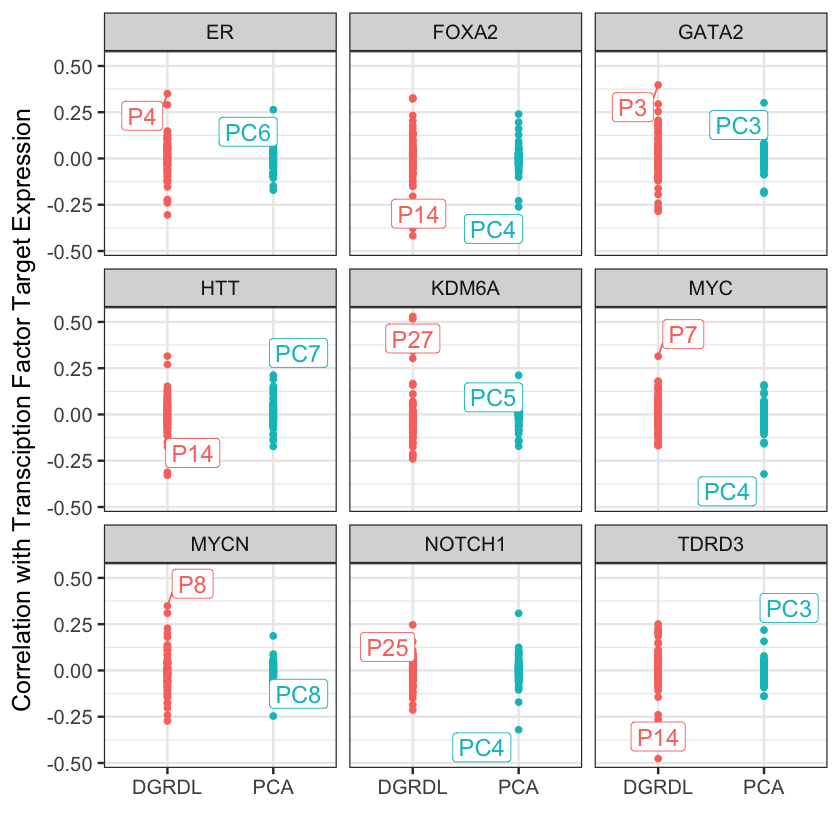

In [450]:
options(repr.plot.width=7, repr.plot.height=7)
tf_cor  %<>% group_by(term,method)  %>% mutate(rank = rank(desc(abs(V1))))  %>% ungroup()
p <- tf_cor  %>% filter(term %in% tf_list)  %>% ggplot(aes(x = method,y = V1,color = method)) + geom_point() + facet_wrap(vars(tf)) + 
    geom_label_repel(data = tf_cor  %>% filter(term %in% tf_list,rank == 1),mapping = aes(x = method,y = V1,label = program),size = 5) +
    theme_bw(base_size = 15) + guides(color = F) + labs(x = "",y = "Correlation with Transciption Factor Target Expression")
    ggsave("./output/dictionary_learning/tf_cor.svg",p,width = 7, height = 7, units = "in",dpi = 300)
p

In [62]:
# Make UMAP embedding of the dictionary


loading_umap <- umap(t(loading), n_neighbors = 15, min_dist = 0.1, metric = "cosine")$layout  %>% as_tibble()

# Make a graph of the dictionary

Warning message:
"The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
i Using compatibility `.name_repair`."


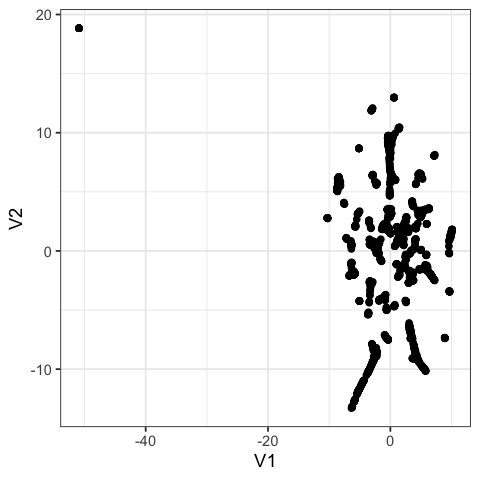

In [63]:
loading_umap %>% ggplot(aes(x = V1, y = V2)) + geom_point() + theme_bw()

In [69]:
corner(loading)

0,0,0.0000000,0,0.00000
0,0,0.0000000,0,0.00000
0,0,0.0000000,0,0.00000
0,0,0.9247107,0,10.08099
0,0,0.0000000,0,0.00000


In [72]:
# get loading where column name starts with "MT-"
loading_mt <- loading[,grep("^INTS", colnames(loading))]
#loading_mt <- loading[,intersect(colnames(loading),c("KRAS","HRAS","NRAS"))]

In [73]:
corner(loading_mt)

INTS11,INTS10,INTS1,INTS2,INTS3
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0


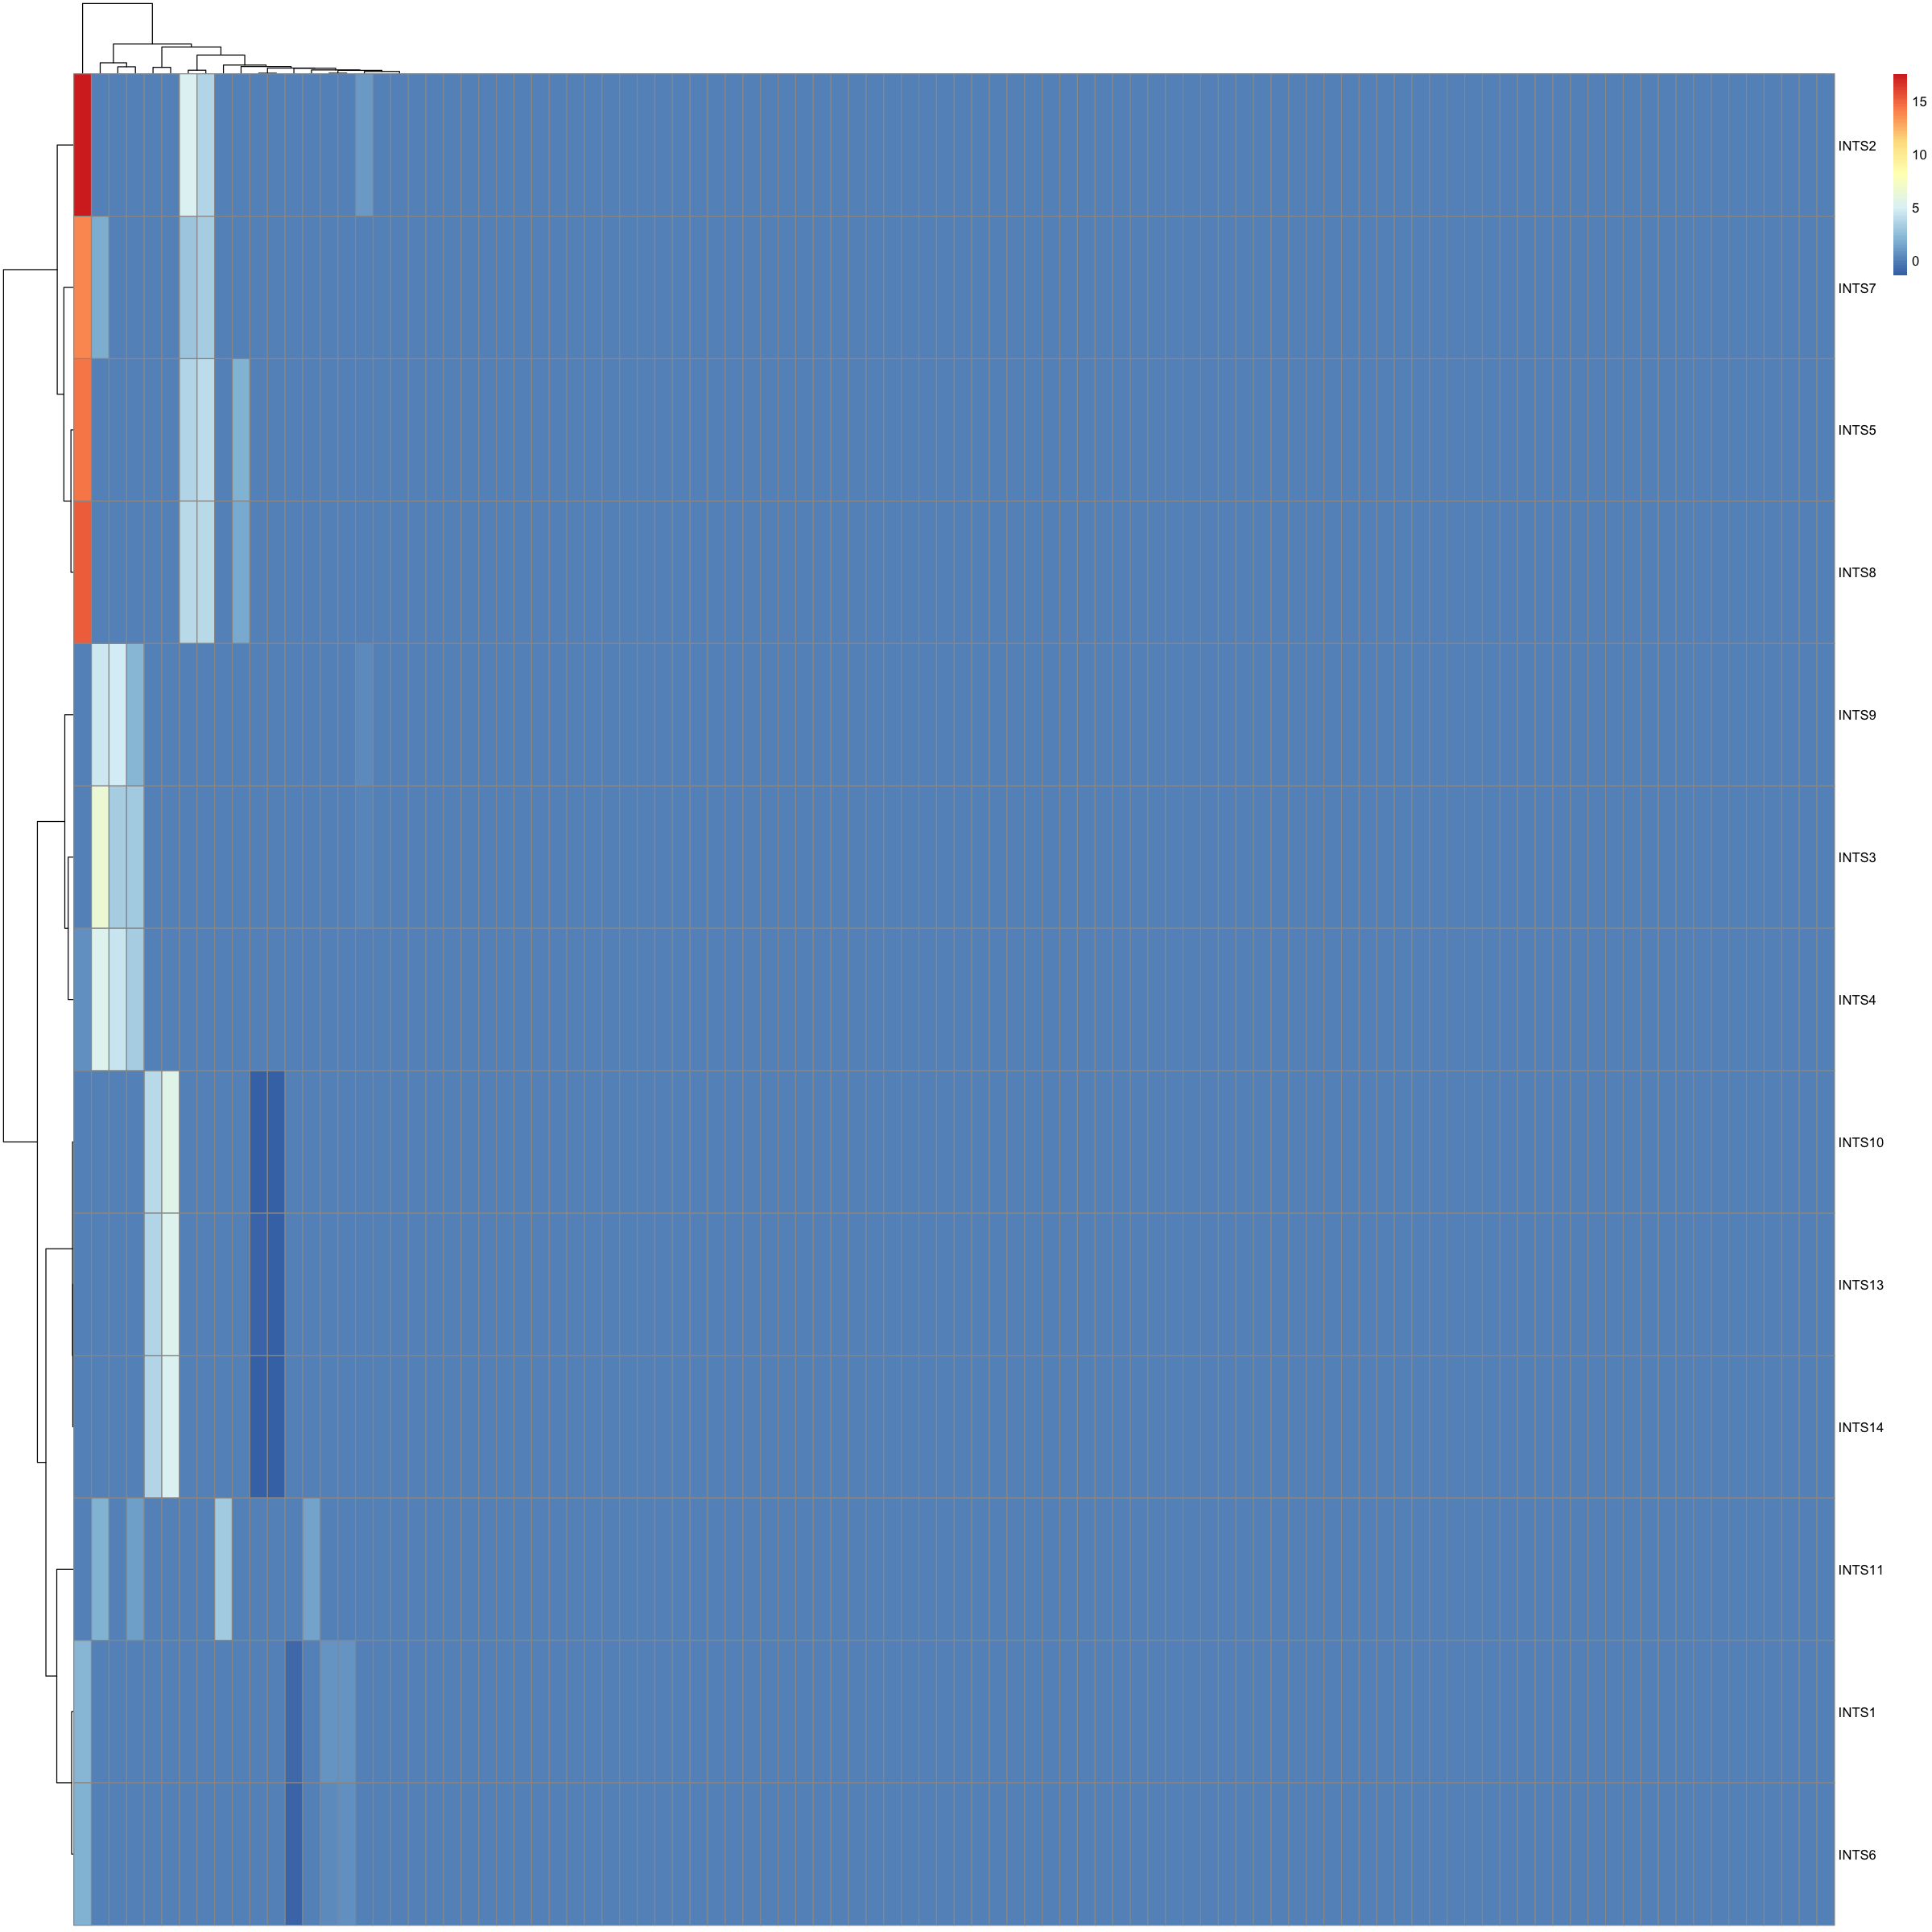

In [74]:
options(repr.plot.width=20, repr.plot.height=20)
pheatmap(t(loading_mt), cluster_rows = T, cluster_cols = T, show_rownames = T, show_colnames = T)

In [76]:
loading_cor <- cor(loading_mt)

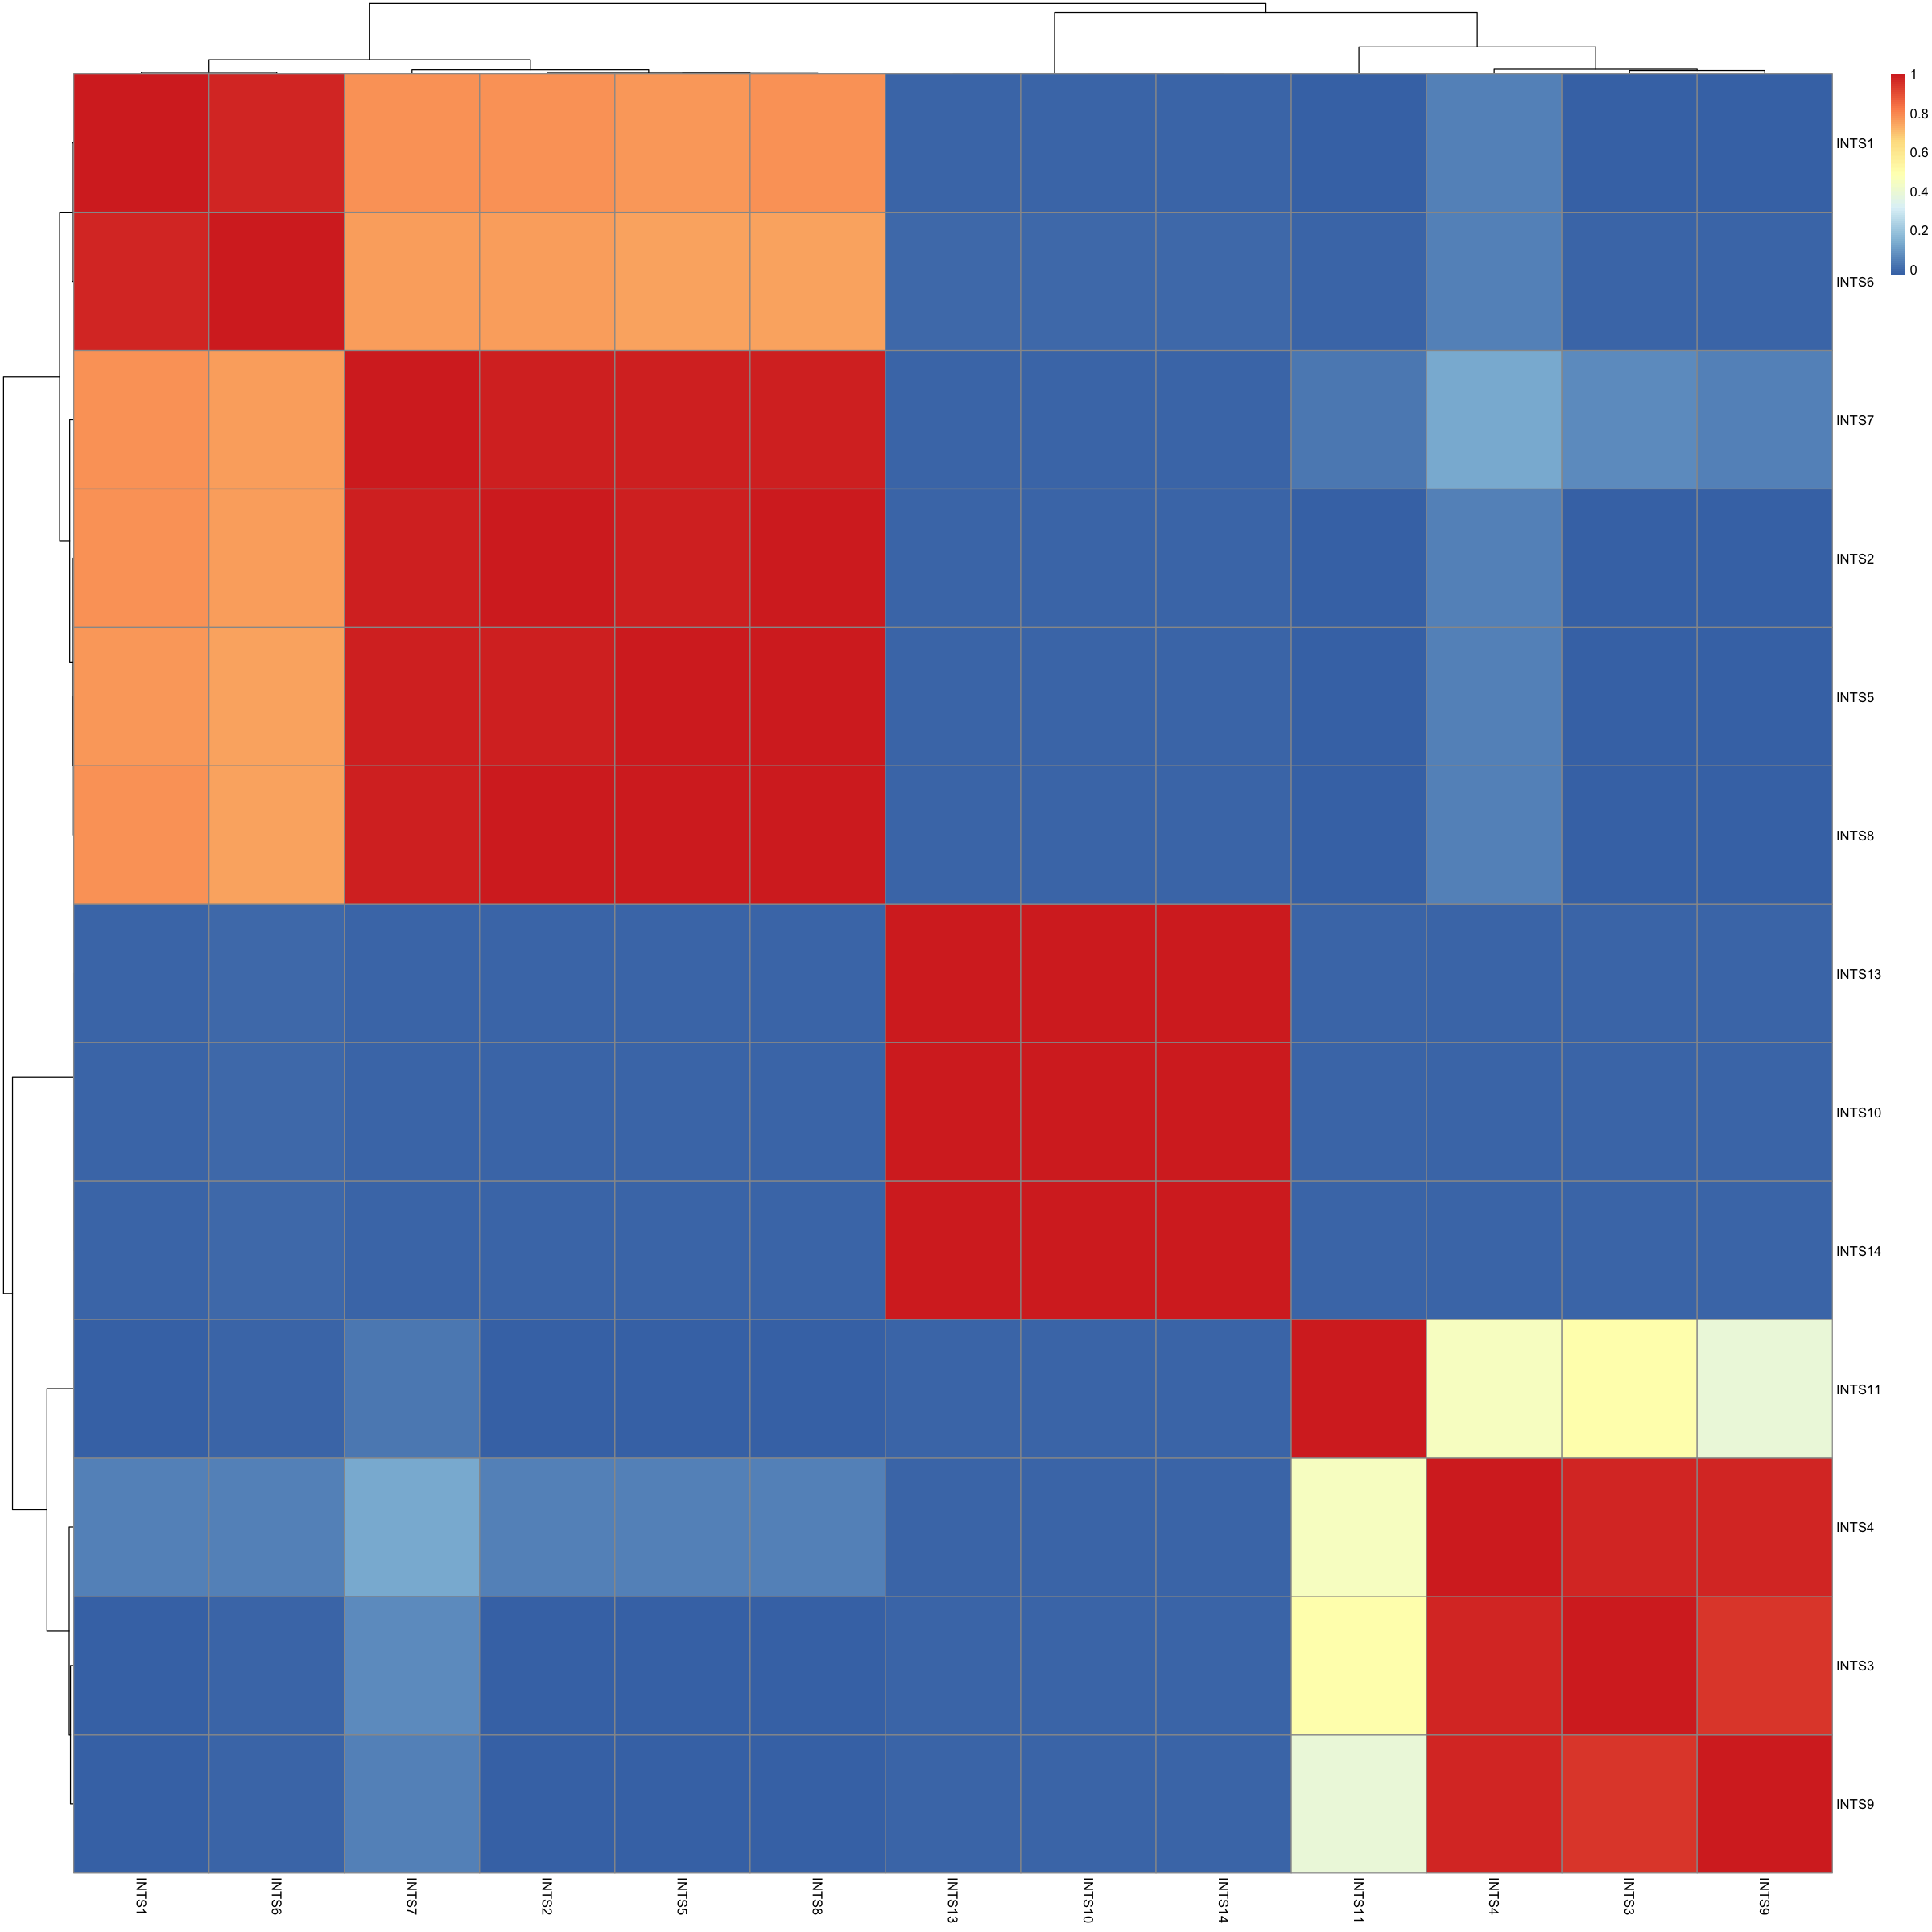

In [77]:
options(repr.plot.width=20, repr.plot.height=20)
pheatmap(loading_cor, cluster_rows = T, cluster_cols = T, show_rownames = T, show_colnames = T)

In [17]:
dim(loading_cor)

[1] 1946 1946

In [12]:
dim(dict)

[1] 1946   40

In [8]:
loading_cor

1.000000000,-0.064868407,6.471104e-01,-0.06507292,0.246965405,0.911538396,-0.059359510,-0.07031448,-0.07900176,0.057386027,⋯,-0.067564223,0.509233750,-0.02893119,0.064850057,-0.05280123,-0.02304207,-0.03872647,-0.068545782,-0.077334698,0.012607406
-0.064868407,1.000000000,-1.846580e-02,0.62248567,-0.110401691,0.080037700,0.421379514,0.35728569,0.37429056,0.731578082,⋯,0.819058051,0.297976847,0.53089126,0.030483364,0.47243231,0.24814159,-0.03810626,0.394323441,-0.062216144,0.305082294
0.647110442,-0.018465804,1.000000e+00,-0.05550261,0.442394985,0.360985131,-0.050629478,-0.06869524,-0.06738294,-0.069180073,⋯,-0.072304914,-0.068500287,-0.07318895,0.019588021,-0.04503573,-0.06015823,-0.09251846,-0.058464721,-0.065961046,-0.059447572
-0.065072917,0.622485666,-5.550261e-02,1.00000000,-0.068286331,-0.029570498,0.826974360,0.72213096,0.80364685,0.883182561,⋯,0.769006538,0.026214729,0.79567527,0.096846880,0.91763511,0.51165131,0.41139906,0.782886528,-0.062412293,0.536896712
0.246965405,-0.110401691,4.423950e-01,-0.06828633,1.000000000,0.097111045,-0.049360733,-0.06697378,-0.06569436,-0.098534183,⋯,-0.117771326,-0.100636869,-0.08920939,-0.009727588,-0.04390716,-0.05865070,-0.03220321,-0.056999629,0.012141501,-0.062607218
0.911538396,0.080037700,3.609851e-01,-0.02957050,0.097111045,1.000000000,-0.060426584,-0.08198818,-0.08042194,0.172426145,⋯,0.036021221,0.748911384,-0.04115863,-0.044921104,-0.05375041,-0.07179921,-0.03942263,-0.069777993,-0.078724903,-0.058922281
-0.059359510,0.421379514,-5.062948e-02,0.82697436,-0.049360733,-0.060426584,1.000000000,0.64674357,0.67425062,0.716214530,⋯,0.574705970,-0.059124165,0.62046927,0.086160260,0.82244669,0.45807163,0.28952191,0.964953158,-0.238078497,0.469512432
-0.070314481,0.357285694,-6.869524e-02,0.72213096,-0.066973781,-0.081988183,0.646743566,1.00000000,0.63468385,0.617083750,⋯,0.506898899,-0.080221031,0.59005602,0.163018252,0.79859709,0.43906925,0.24745071,0.607971319,-0.077247314,0.486796539
-0.079001764,0.374290561,-6.738294e-02,0.80364685,-0.065694360,-0.080421937,0.674250620,0.63468385,1.00000000,0.644709397,⋯,0.699072000,-0.078688543,0.64472788,0.063526317,0.75214258,0.78091452,0.40489010,0.634548074,-0.075771634,0.417799826
0.057386027,0.731578082,-6.918007e-02,0.88318256,-0.098534183,0.172426145,0.716214530,0.61708375,0.64470940,1.000000000,⋯,0.823499558,0.292796320,0.69493561,0.069151617,0.79852392,0.43331492,0.27550161,0.674447824,-0.077792501,0.472278061
0.657309882,0.246165807,9.854972e-05,0.01859044,-0.072504345,0.900751834,-0.052574493,-0.07133429,-0.06997156,0.281753478,⋯,0.179161485,0.904444297,0.02001381,-0.049926600,-0.04676585,-0.06246931,-0.03429989,-0.060710740,-0.068495050,-0.036728896


In [37]:
# make heatmap of loading correlation
library(pheatmap)

loading_cor <- cor(loading)
pheatmap(loading_cor, cluster_rows = F, cluster_cols = F)

: 

: 

In [25]:
umap_mat

1.839174987,-0.04434889
0.057757393,0.10844815
-0.509708036,2.83362174
-1.571776407,2.98799805
0.591216258,1.68227479
-0.849149302,-2.03666366
0.769032200,-0.89600611
-1.377437627,0.06189760
-1.724115486,1.25656303
-1.506527518,3.06505661
1.198290328,-0.74446934
